In [3]:
# %reset
import sys, os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['JAX_ENABLE_X64'] = 'True'
from jax import config
config.update("jax_enable_x64", True)

# JAX_ENABLE_X64=True
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# Change the current working directory to the desired path
# os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
import pathlib
curr_path = pathlib.Path().absolute()
# Let's assume that we have a relative path to a file or directory (rel_path) within our current working directory.

abs_path_data = os.path.abspath(curr_path / "../../data/") 
abs_path_src = os.path.abspath(curr_path / "../../src/") 

sys.path.append((curr_path))
sys.path.append((abs_path_data))

sys.path.append(abs_path_src)

# from jax import config
# config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2
%reload_ext autocomplete





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# abs_path_data
import os
from get_power_spectra_NO_CONC_jit import get_power_BCMP_NO_CONC
from setup_power_spectra_NO_CONC_jit import setup_power_BCMP_NO_CONC
import jax.numpy as jnp
from jax import grad, jit, vmap
import numpy as np
import jax.scipy.integrate as jsi
from jax_cosmo import Cosmology
from functools import partial
import astropy.units as u
from astropy import constants as const
RHO_CRIT_0_MPC3 = 2.77536627245708E11
G_new = ((const.G * (u.M_sun / u.Mpc**3) * (u.M_sun) / (u.Mpc)).to(u.eV / u.cm**3)).value
# from transforms import Hankel
# from mcfit import Hankel
from mcfitjax.transforms import Hankel
import time
from twobessel import *
import interpax



In [9]:
# !pip install interpax


In [18]:
# cosmo_params_dict = {'flat': True, 'H0': 70.0, 'Om0': 0.2793, 'Ob0': 0.0463, 'sigma8': 0.821, 'ns': 0.972, 'w0':-1.0}
# cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.31, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95, 'w0':-1.0}
cosmo_params_dict = {'flat': True, 'H0': 67.2, 'Om0': 0.29, 'Ob0': 0.049, 'sigma8': 0.783, 'ns': 0.95, 'w0':-1.0}
sim_params_dict = {}
sim_params_dict['nfw_trunc'] = True
sim_params_dict['gamma_rhogas'] = 2.0
sim_params_dict['delta_rhogas'] = 7.0
# sim_params_dict['theta_co'] = 0.01
# sim_params_dict['theta_ej'] = 1.0

sim_params_dict['theta_co_0'] = 0.1
sim_params_dict['log10_Mstar0_theta_co'] = 14.0
sim_params_dict['nu_theta_co_M'] = 0.0
sim_params_dict['nu_theta_co_z'] = 0.0

sim_params_dict['theta_ej_0'] = 2.75
sim_params_dict['log10_Mstar0_theta_ej'] = 14.0
sim_params_dict['nu_theta_ej_M'] = 0.0
sim_params_dict['nu_theta_ej_z'] = 0.0

sim_params_dict['log10_Mc0'] = 14.83
sim_params_dict['log10_Mstar0'] = 14.0
sim_params_dict['mu_beta'] = 0.21
sim_params_dict['nu_z'] = 0.0
sim_params_dict['nu_M'] = 0.0

sim_params_dict['eta_star'] = 0.3
sim_params_dict['eta_cga'] = 0.6


sim_params_dict['neg_bhse_plus_1'] = 0.833
sim_params_dict['A_starcga'] = 0.09
sim_params_dict['log10_M1_starcga'] = 11.4
sim_params_dict['epsilon_rt'] = 4.0


sim_params_dict['a_zeta'] = 0.3
sim_params_dict['n_zeta'] = 2
sim_params_dict['alpha_nt'] = 0.18
sim_params_dict['beta_nt'] = 0.5
sim_params_dict['n_nt'] = 0.3
sim_params_dict['cosmo'] = cosmo_params_dict


halo_params_dict = {}
halo_params_dict['rmin'], halo_params_dict['rmax'], halo_params_dict['nr'] = 5e-3, 12, 32
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 0.002, 2
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.001, 1.0, 10
# halo_params_dict['z_array'] = np.array([1e-3, 0.5, 1.0])
# halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.01, 3.0, 20
halo_params_dict['zmin'], halo_params_dict['zmax'], halo_params_dict['nz'] = 0.01, 3.0, 24
# halo_params_dict['z_array'] = np.array([1e-3])
# halo_params_dict['z_array'] = np.array([0.5])
# halo_params_dict['z_array'] = np.array([1.0])
# halo_params_dict['nz'] = len(halo_params_dict['z_array'])
# halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 12.0, 15.5, 20
halo_params_dict['lg10_Mmin'], halo_params_dict['lg10_Mmax'], halo_params_dict['nM'] = 11.0, 16.0, 32
halo_params_dict['cmin'], halo_params_dict['cmax'], halo_params_dict['nc'] = 2, 9, 16

lmin = 1.0
lmax = 60000.0
fac = 1
dl_log_array = 0.23025851 / fac
# dl_log_array = 0.1
l_array_all = np.exp(np.arange(np.log(lmin), np.log(lmax), dl_log_array))
dl_array = l_array_all[1:] - l_array_all[:-1]
l_array_survey = (l_array_all[1:] + l_array_all[:-1]) / 2.
halo_params_dict['ell_array'] = jnp.array(l_array_survey)
halo_params_dict['nell'] = len(l_array_survey)
halo_params_dict['ellmin'] = l_array_survey[0]
halo_params_dict['ellmax'] = l_array_survey[-1]
# halo_params_dict['ellmin'], halo_params_dict['ellmax'], halo_params_dict['nell'] = 8, 2**14, 32
# try:
halo_params_dict['sig_logc_z_array'] = np.ones(halo_params_dict['nz']) * 0.05
halo_params_dict['mdef'] = '200c'
halo_params_dict['hmf_model'] = 'T10'
# halo_params_dict['conc_model'] = 'Diemer15'
halo_params_dict['conc_model'] = 'Duffy08'
halo_params_dict['do_corr_2h_mm'] = True

# halo_params_dict['do_corr_2h_mm'] = False

from astropy.io import fits
df = fits.open(os.path.abspath(abs_path_data + '/DESxACT/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits'))
# df = fits.open('data/DESxACT/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits') 
z_array = df['nz_source'].data['Z_MID']
nz_info_dict = {}
nz_info_dict['z_array'] = z_array
nz_info_dict['nbins'] = 4
nz_info_dict['nz0'] = np.maximum(df['nz_source'].data['BIN1'], 1e-4)
nz_info_dict['nz1'] = np.maximum(df['nz_source'].data['BIN2'], 1e-4)
nz_info_dict['nz2'] = np.maximum(df['nz_source'].data['BIN3'], 1e-4)
nz_info_dict['nz3'] = np.maximum(df['nz_source'].data['BIN4'], 1e-4)
# nz_info_dict['nz4'] = np.maximum(df['nz_source'].data['BIN5'], 1e-4)
analysis_dict = {}
analysis_dict['nz_info_dict'] = nz_info_dict
analysis_dict['do_sheary'] = True
analysis_dict['do_shear2pt'] = True
analysis_dict['do_yy'] = True

analysis_dict['fsky_yy'] = 0.1
analysis_dict['fsky_ky'] = 0.1
analysis_dict['fsky_kk'] = 0.1
analysis_dict['fac_ell_hres'] = fac

# df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DESxACT/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits')
# df_data = fits.open('/mnt/home/spandey/ceph/GODMAX/data/DESxACT/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits')
theta_data = df['xip'].data['ANG'][0:20]

# analysis_dict['ellmin_transf'], analysis_dict['ellmax_transf'], analysis_dict['nell_transf'] = 8, 2**15, 16384
analysis_dict['angles_data_array'] = jnp.array(theta_data)
analysis_dict['beam_fwhm_arcmin'] = 1.6
analysis_dict['want_like_diff'] = True
analysis_dict['calc_nfw_only'] = False
analysis_dict['conc_dep_model'] = False


analysis_dict['get_cov'] = True
# analysis_dict['stats_for_cov'] = ['ky']
analysis_dict['stats_for_cov'] = ['ky', 'kk']
analysis_dict['analysis_coords'] = 'real'
# l_array_survey = np.logspace(np.log10(lmin), np.log10(lmax), int((lmax-lmin)/dl_log_array)+1)
analysis_dict['l_array_survey'] = jnp.array(l_array_survey)
analysis_dict['dl_array_survey'] = jnp.array(dl_array)
# analysis_dict['yy_total_ell_fname'] = '/Users/shivam/Downloads/ACT_Cls/Cls_ilc_SZ_deproj_cib_cibdBeta_1.7_10.7_yy_apod10arcmin_21Mar24.txt'
# analysis_dict['yy_total_ell_fname'] = '/Users/shivam/Downloads/ACT_Cls/Cls_ilc_SZ_yy_apod10arcmin_21Mar24.txt'
analysis_dict['yy_total_ell_fname'] = os.path.abspath(abs_path_data + '/DESxACT/ACT_Cls/Cls_ilc_SZ_yy_apod10arcmin_21Mar24.txt')
analysis_dict['sigma_epsilon_SN_bins'] = [0.2724, 0.2724, 0.2724, 0.2724]
analysis_dict['neff_arcmin2_SN_bins'] = [1.7971, 1.5521, 1.5967, 1.0979]

other_params_dict = {}
other_params_dict['A_IA'] = 0.0
other_params_dict['eta_IA'] = 0.0
other_params_dict['z0_IA'] = 0.62
other_params_dict['C1_rhocrit'] = 0.0134
other_params_dict['Delta_z_bias_array'] = np.zeros(nz_info_dict['nbins'])
other_params_dict['mult_shear_bias_array'] = np.zeros(nz_info_dict['nbins'])





In [19]:
neff_arcmin2_SN_bins = analysis_dict['neff_arcmin2_SN_bins']
sigma_epsilon_SN_bins = analysis_dict['sigma_epsilon_SN_bins']
jb1 = 3
neff_rad2_from_arcmin2 = neff_arcmin2_SN_bins[jb1] * (180 * 60./ jnp.pi)**2
shape_noise_jb = ((sigma_epsilon_SN_bins[jb1]**2)/neff_rad2_from_arcmin2) * jnp.ones(len(l_array_survey))
print(shape_noise_jb[0])



5.7187835045775756e-09


In [12]:
import itertools
import scipy as sp
import math

class get_cov:
    def __init__(self,
                sim_params_dict,
                halo_params_dict,
                analysis_dict,
                other_params_dict=None,
                num_points_trapz_int=64,
                setup_power_BCMP_obj=None,
                get_power_BCMP_obj=None,
                verbose_time=False
                ):

        self.verbose = verbose_time
        if verbose_time:
            t0 = time.time()

        self.cosmo_params = sim_params_dict['cosmo']

        if verbose_time:
            ti = time.time()
        if setup_power_BCMP_obj is None:
            setup_power_BCMP_obj = setup_power_BCMP_NO_CONC(sim_params_dict, halo_params_dict, analysis_dict, other_params_dict, verbose_time=verbose_time)            
        if get_power_BCMP_obj is None:
            get_power_BCMP_obj = get_power_BCMP_NO_CONC(sim_params_dict, halo_params_dict, analysis_dict, other_params_dict, num_points_trapz_int=num_points_trapz_int, setup_power_BCMP_obj=setup_power_BCMP_obj, verbose_time=verbose_time)
        if verbose_time:
            print('Time for setup_power_BCMP: ', time.time() - ti)
            ti = time.time()

        analysis_coords = analysis_dict['analysis_coords']
        beam_fwhm_arcmin = analysis_dict['beam_fwhm_arcmin']
        l_array_survey = analysis_dict['l_array_survey']
        beam_fwhm_arcmin = analysis_dict['beam_fwhm_arcmin']

        fac_ell_hres = analysis_dict['fac_ell_hres']

        if beam_fwhm_arcmin > 0.:
            self.add_beam_to_theory = True
        else:
            self.add_beam_to_theory = False
        ell_array_calc = setup_power_BCMP_obj.ell_array

        if np.allclose(l_array_survey, ell_array_calc):
            do_interpolation = False
        else:
            do_interpolation = True
        
        if verbose_time:
            print('do_interpolation: ', do_interpolation)

        dl_array_survey = analysis_dict['dl_array_survey']        
        self.nell, self.nM, self.nz = setup_power_BCMP_obj.nell, setup_power_BCMP_obj.nM, setup_power_BCMP_obj.nz

        self.dndlnM_z = setup_power_BCMP_obj.hmf_Mz_mat
        self.chi_array = setup_power_BCMP_obj.chi_array
        self.M_array = setup_power_BCMP_obj.M_array
        self.z_array = setup_power_BCMP_obj.z_array
        self.dchi_dz_array = get_power_BCMP_obj.dchi_dz_array

        self.fsky_dict = {
            'yy': analysis_dict.get('fsky_yy',0.1),
            'yk': analysis_dict.get('fsky_ky',0.1),
            'ky': analysis_dict.get('fsky_ky',0.1),
            'kk': analysis_dict.get('fsky_kk',0.1),
            }

        self.stats_analyze = analysis_dict['stats_for_cov']
        stats_analyze_pairs = []
        stats_analyze_pairs_all = []
        index_params = range(len(self.stats_analyze))
        for j1 in index_params:
            for j2 in index_params:
                if j2 >= j1:
                    stats_analyze_pairs.append([self.stats_analyze[j1], self.stats_analyze[j2]])

                stats_analyze_pairs_all.append([self.stats_analyze[j1], self.stats_analyze[j2]])

        self.stats_analyze_pairs = stats_analyze_pairs
        self.stats_analyze_pairs_all = stats_analyze_pairs_all

        self.Cl_result_dict = {}
        self.Cl_result_dict['l_array_survey'] = l_array_survey
        self.Cl_result_dict['dl_array_survey'] = dl_array_survey
        self.Cl_result_dict['yy'] = {}
        self.Cl_result_dict['yy']['bin_' + '0_0'] = {}
        if do_interpolation:
            log_Cl_yy_interp = interpax.Interpolator1D(
                jnp.log(get_power_BCMP_obj.ell_array), jnp.log(jnp.abs(get_power_BCMP_obj.Cl_y_y_1h_mat + get_power_BCMP_obj.Cl_y_y_2h_mat) + 1e-25)
                )
            self.Cl_result_dict['yy']['bin_' + '0_0']['tot_ellsurvey'] = jnp.exp(log_Cl_yy_interp(jnp.log(l_array_survey)))
        else:
            self.Cl_result_dict['yy']['bin_' + '0_0']['tot_ellsurvey'] = get_power_BCMP_obj.Cl_y_y_1h_mat + get_power_BCMP_obj.Cl_y_y_2h_mat
        
        yy_noise_ell_fname = analysis_dict.get('yy_noise_ell_fname',None)
        yy_total_ell_fname = analysis_dict.get('yy_total_ell_fname',None)
        sigma_epsilon_SN_bins = analysis_dict.get('sigma_epsilon_SN_bins',jnp.zeros(get_power_BCMP_obj.nbins))
        neff_arcmin2_SN_bins = analysis_dict.get('neff_arcmin2_SN_bins',jnp.ones(get_power_BCMP_obj.nbins))

        if yy_total_ell_fname is not None:
            ell_yy_tot, Cl_yy_tot = np.loadtxt(yy_total_ell_fname, unpack  = True)
            log_Cl_yy_tot_interp = interpax.Interpolator1D(
                jnp.log(ell_yy_tot), jnp.log(Cl_yy_tot + 1e-25), extrap=(math.log(Cl_yy_tot[0]), math.log(Cl_yy_tot[-1])))
            # log_Cl_yy_tot_interp = interpax.Interpolator1D(
            #     jnp.log(ell_yy_tot), jnp.log(Cl_yy_tot + 1e-25), extrap=-120)
            Cl_yy_tot = jnp.exp(log_Cl_yy_tot_interp(jnp.log(l_array_survey)))
            self.Cl_result_dict['yy']['bin_' + '0_0']['tot_plus_noise_ellsurvey'] = Cl_yy_tot
        elif yy_noise_ell_fname is not None:
            ell_yy_noise, Cl_yy_noise = np.loadtxt(yy_noise_ell_fname, unpack = True)
            log_Cl_yy_noise_interp = interpax.Interpolator1D(
                jnp.log(ell_yy_noise), jnp.log(jnp.abs(Cl_yy_noise)) + 1e-25, extrap=True
            )
            noise_yy = jnp.exp(log_Cl_yy_noise_interp(jnp.log(l_array_survey)))
            self.Cl_result_dict['yy']['bin_' + '0_0']['tot_plus_noise_ellsurvey'] = self.Cl_result_dict['yy']['0_0']['tot_ellsurvey'] + noise_yy
        else:
            # print a warning:
            print('Warning: no yy-total or yy-noise file found')
            self.Cl_result_dict['yy']['bin_' + '0_0']['tot_plus_noise_ellsurvey'] = self.Cl_result_dict['yy']['0_0']['tot_ellsurvey']
        self.Cl_result_dict['yy']['bin_combs'] = [[0,0]]

        if do_interpolation:
            log_Cl_ky_interp = interpax.Interpolator2D(
                jnp.arange(get_power_BCMP_obj.nbins), jnp.log(get_power_BCMP_obj.ell_array),
                jnp.log(jnp.abs(get_power_BCMP_obj.Cl_kappa_y_1h_mat + get_power_BCMP_obj.Cl_kappa_y_2h_mat) + 1e-25)
                )
            
            log_Cl_kk_interp = interpax.Interpolator3D(
                jnp.arange(get_power_BCMP_obj.nbins), jnp.arange(get_power_BCMP_obj.nbins), jnp.log(get_power_BCMP_obj.ell_array),
                jnp.log(jnp.abs(get_power_BCMP_obj.Cl_kappa_kappa_1h_mat + get_power_BCMP_obj.Cl_kappa_kappa_2h_mat) + 1e-25)
                )

        bin_combs_ky = []
        bin_combs_kk = []        
        self.Cl_result_dict['ky'] = {}
        self.Cl_result_dict['kk'] = {}
        for jb1 in range(get_power_BCMP_obj.nbins):
            self.Cl_result_dict['ky']['bin_' + str(jb1+1) + '_' + str(0)] = {}       
            if do_interpolation:             
                self.Cl_result_dict['ky']['bin_' + str(jb1+1) + '_' + str(0)]['tot_ellsurvey'] = jnp.exp(log_Cl_ky_interp(jb1, jnp.log(l_array_survey)))
            else:
                self.Cl_result_dict['ky']['bin_' + str(jb1+1) + '_' + str(0)]['tot_ellsurvey'] = (get_power_BCMP_obj.Cl_kappa_y_1h_mat + get_power_BCMP_obj.Cl_kappa_y_2h_mat)[jb1,:]
            self.Cl_result_dict['ky']['bin_' + str(jb1+1) + '_' + str(0)]['tot_plus_noise_ellsurvey'] = self.Cl_result_dict['ky']['bin_' + str(jb1+1) + '_' + str(0)]['tot_ellsurvey']
            bin_combs_ky.append([jb1+1, 0])
            for jb2 in range(get_power_BCMP_obj.nbins):
                self.Cl_result_dict['kk']['bin_' + str(jb1+1) + '_' + str(jb2+1)] = {}   
                if do_interpolation:             
                    self.Cl_result_dict['kk']['bin_' + str(jb1+1) + '_' + str(jb2+1)]['tot_ellsurvey'] = jnp.exp(log_Cl_kk_interp(jb1, jb2, jnp.log(l_array_survey)))
                else:
                    self.Cl_result_dict['kk']['bin_' + str(jb1+1) + '_' + str(jb2+1)]['tot_ellsurvey'] = (get_power_BCMP_obj.Cl_kappa_kappa_1h_mat + get_power_BCMP_obj.Cl_kappa_kappa_2h_mat)[jb1, jb2, :]
                bin_combs_kk.append([jb1+1, jb2+1])                
                if jb1 == jb2:
                    neff_rad2_from_arcmin2 = neff_arcmin2_SN_bins[jb1] * (180 * 60./ jnp.pi)**2
                    shape_noise_jb = ((sigma_epsilon_SN_bins[jb1]**2)/neff_rad2_from_arcmin2) * jnp.ones(len(l_array_survey))
                    self.Cl_result_dict['kk']['bin_' + str(jb1+1) + '_' + str(jb2+1)]['noise_ellsurvey'] = shape_noise_jb
                    self.Cl_result_dict['kk']['bin_' + str(jb1+1) + '_' + str(jb2+1)]['tot_plus_noise_ellsurvey'] = self.Cl_result_dict['kk']['bin_' + str(jb1+1) + '_' + str(jb2+1)]['tot_ellsurvey'] + shape_noise_jb
                else:
                    self.Cl_result_dict['kk']['bin_' + str(jb1+1) + '_' + str(jb2+1)]['tot_plus_noise_ellsurvey'] = self.Cl_result_dict['kk']['bin_' + str(jb1+1) + '_' + str(jb2+1)]['tot_ellsurvey']

        self.Cl_result_dict['ky']['bin_combs'] = bin_combs_ky
        self.Cl_result_dict['kk']['bin_combs'] = bin_combs_kk

        ul_dict = {}
        if do_interpolation:
            log_uyl_interp = interpax.Interpolator3D(
                jnp.log(setup_power_BCMP_obj.ell_array), setup_power_BCMP_obj.z_array, jnp.log(setup_power_BCMP_obj.M_array),
                jnp.log(jnp.abs(setup_power_BCMP_obj.uyl_mat) + 1e-25)
                )     
            ul_dict['y_0'] = jnp.exp(log_uyl_interp(jnp.log(l_array_survey), setup_power_BCMP_obj.z_array, jnp.log(setup_power_BCMP_obj.M_array)))
        else:
            ul_dict['y_0'] = setup_power_BCMP_obj.uyl_mat

        for jb in range(get_power_BCMP_obj.nbins):
            if do_interpolation:
                log_ukl_interp = interpax.Interpolator3D(
                    jnp.log(setup_power_BCMP_obj.ell_array), setup_power_BCMP_obj.z_array, jnp.log(setup_power_BCMP_obj.M_array),
                    jnp.log(jnp.abs(get_power_BCMP_obj.ukappa_l_for_cov[jb,...]) + 1e-25)
                    )
                ul_dict['k_' + str(jb+1)] = jnp.exp(log_ukl_interp(jnp.log(l_array_survey), setup_power_BCMP_obj.z_array, jnp.log(setup_power_BCMP_obj.M_array)))                
            else:
                ul_dict['k_' + str(jb+1)] = get_power_BCMP_obj.ukappa_l_for_cov[jb,...]

            
        if self.verbose:
            print(list(self.Cl_result_dict['kk'].keys()))
        if analysis_coords == 'real':
            if self.verbose:
                print('setting up realspace covariance')

            isodd = 0
            ell_temp = l_array_survey

            if np.mod(len(ell_temp), 2) > 0:
                isodd = 1
                ell = ell_temp[:-1]
            else:
                ell = ell_temp
            nl = len(ell)
            dlnk = fac_ell_hres * np.log(ell[1] / ell[0])
            ell_mat = np.tile(ell.reshape(nl, 1), (1, nl))
            ell1_ell2 = ell_mat * ell_mat.T
            self.fftcovtot_dict = {}

        self.covG_dict = {}
        self.covNG_dict = {}
        self.covtot_dict = {}
        if analysis_coords == 'real':
            self.fftcovtot_dict = {}

        for j in range(len(self.stats_analyze_pairs)):
            stats_analyze_1, stats_analyze_2 = self.stats_analyze_pairs[j]
            if self.verbose:
                print('starting covariance of ' + str(stats_analyze_1) + ' and ' + str(stats_analyze_2))
            if stats_analyze_1 in self.Cl_result_dict.keys():
                stats_analyze_1_ordered = stats_analyze_1
            else:
                stats_analyze_1_ordered = list(stats_analyze_1)[1] + list(stats_analyze_1)[0]
            bin_combs_stat1 = self.Cl_result_dict[stats_analyze_1_ordered]['bin_combs']
            bins1_stat1 = []
            bins2_stat1 = []
            for jb in range(len(bin_combs_stat1)):
                bins1_stat1.append(bin_combs_stat1[jb][0])
                bins2_stat1.append(bin_combs_stat1[jb][1])

            if stats_analyze_2 in self.Cl_result_dict.keys():
                stats_analyze_2_ordered = stats_analyze_2
            else:
                stats_analyze_2_ordered = list(stats_analyze_2)[1] + list(stats_analyze_2)[0]
            bin_combs_stat2 = self.Cl_result_dict[stats_analyze_2_ordered]['bin_combs']
            bins1_stat2 = []
            bins2_stat2 = []
            for jb in range(len(bin_combs_stat2)):
                bins1_stat2.append(bin_combs_stat2[jb][0])
                bins2_stat2.append(bin_combs_stat2[jb][1])

            covG_stat12 = {}
            covNG_stat12 = {}
            covtot_stat12 = {}
            isgtykk, isgtygty, iskkkk, isgygy = False, False, False, False
            if analysis_coords == 'real':
                fftcovtot_stat12 = {}
                fftmcovtot_stat12 = {}
                fftpmcovtot_stat12 = {}
                if (stats_analyze_1_ordered == 'ky') and (stats_analyze_2_ordered == 'ky'):
                    gtfftcovtot_stat12 = {}
                    isgtygty = True
                # if (stats_analyze_1_ordered == 'gy') and (stats_analyze_2_ordered == 'gy'):
                #     isgygy = True
                if (stats_analyze_1_ordered == 'kk') and (stats_analyze_2_ordered == 'kk'):
                    iskkkk = True
                if ((stats_analyze_1_ordered == 'kk') and
                    (stats_analyze_2_ordered
                        == 'ky')) or ((stats_analyze_1_ordered == 'ky') and (stats_analyze_2_ordered == 'kk')):
                    kkgtfftcovtot_stat12 = {}
                    kkmgtfftcovtot_stat12 = {}
                    isgtykk = True
            bins_comb = []
            for jb1 in range(len(bins1_stat1)):
                for jb2 in range(len(bins1_stat2)):
                    if self.verbose:
                        print(
                            stats_analyze_1_ordered, stats_analyze_2_ordered, bins1_stat1[jb1], bins2_stat1[jb1],
                            bins1_stat2[jb2], bins2_stat2[jb2]
                            )

                    covG = self.get_cov_G(
                        bins1_stat1[jb1], bins2_stat1[jb1], bins1_stat2[jb2], bins2_stat2[jb2],
                        stats_analyze_1_ordered, stats_analyze_2_ordered, self.Cl_result_dict, self.fsky_dict
                        )

                    A, B = list(stats_analyze_1_ordered)
                    C, D = list(stats_analyze_2_ordered)

                    uAl_zM_dict = ul_dict[A + '_' + str(bins1_stat1[jb1])]
                    uBl_zM_dict = ul_dict[B + '_' + str(bins2_stat1[jb1])]
                    uCl_zM_dict = ul_dict[C + '_' + str(bins1_stat2[jb2])]
                    uDl_zM_dict = ul_dict[D + '_' + str(bins2_stat2[jb2])]

                    covNG = self.get_cov_NG(
                        l_array_survey, stats_analyze_1_ordered, stats_analyze_2_ordered,
                        False, self.fsky_dict, uAl_zM_dict, uBl_zM_dict, uCl_zM_dict, uDl_zM_dict,
                        beam_fwhm_arcmin
                        )

                    covtot = covG + covNG
                    # covtot = covG
                    # covtot = covNG
                    bin_key = 'bin_' + str(bins1_stat1[jb1]) + '_' + str(bins2_stat1[jb1]) + '_' + str(
                        bins1_stat2[jb2]
                        ) + '_' + str(bins2_stat2[jb2])
                    covG_stat12[bin_key] = covG
                    covNG_stat12[bin_key] = covNG
                    covtot_stat12[bin_key] = covtot
                    bins_comb.append([bins1_stat1[jb1], bins2_stat1[jb1], bins1_stat2[jb2], bins2_stat2[jb2]])
                    if analysis_coords == 'real':
                        if isodd:
                            covtot_rs = covtot[:-1, :][:, :-1]
                        else:
                            covtot_rs = covtot
                        newtwobessel = two_Bessel(
                            ell,
                            ell,
                            covtot_rs * (ell1_ell2**2) * (1. / (4 * np.pi**2)),
                            nu1=1.05,
                            nu2=1.05,
                            N_extrap_low=0,
                            N_extrap_high=0,
                            c_window_width=0.25,
                            N_pad=32
                            )
                        t1, t2, cov_fft = newtwobessel.two_Bessel_binave(0, 0, dlnk, dlnk)
                        theta_vals_arcmin_fft = (t1[:-1] + t1[1:]) / 2. / np.pi * 180 * 60
                        cov_tot_fft = cov_fft[:, :-1][:-1, :]
                        fftcovtot_stat12[bin_key] = cov_tot_fft
                        # import pdb; pdb.set_trace()

                        if iskkkk:
                            t1, t2, cov_fft = newtwobessel.two_Bessel_binave(4, 4, dlnk, dlnk)
                            theta_vals_arcmin_fft = (t1[:-1] + t1[1:]) / 2. / np.pi * 180 * 60
                            cov_tot_fftm = cov_fft[:, :-1][:-1, :]
                            fftmcovtot_stat12[bin_key] = cov_tot_fftm

                            t1, t2, cov_fft = newtwobessel.two_Bessel_binave(4, 0, dlnk, dlnk)
                            theta_vals_arcmin_fft = (t1[:-1] + t1[1:]) / 2. / np.pi * 180 * 60
                            cov_tot_fftm = cov_fft[:, :-1][:-1, :]
                            fftpmcovtot_stat12[bin_key] = cov_tot_fftm

                        if isgtygty:
                            t1, t2, covgt_fft = newtwobessel.two_Bessel_binave(2, 2, dlnk, dlnk)
                            gtfftcovtot_stat12[bin_key] = covgt_fft[:, :-1][:-1, :]
                            theta_vals_arcmin_fft = (t1[:-1] + t1[1:]) / 2. / np.pi * 180 * 60
                            if 'theta' not in gtfftcovtot_stat12.keys():
                                gtfftcovtot_stat12['theta'] = theta_vals_arcmin_fft

                        if isgtykk:
                            t1, t2, covgt_fft = newtwobessel.two_Bessel_binave(2, 0, dlnk, dlnk)
                            kkgtfftcovtot_stat12[bin_key] = covgt_fft[:, :-1][:-1, :]
                            theta_vals_arcmin_fft = (t1[:-1] + t1[1:]) / 2. / np.pi * 180 * 60
                            if 'theta' not in kkgtfftcovtot_stat12.keys():
                                kkgtfftcovtot_stat12['theta'] = theta_vals_arcmin_fft

                            t1, t2, covgt_fft = newtwobessel.two_Bessel_binave(2, 4, dlnk, dlnk)
                            kkmgtfftcovtot_stat12[bin_key] = covgt_fft[:, :-1][:-1, :]
                            theta_vals_arcmin_fft = (t1[:-1] + t1[1:]) / 2. / np.pi * 180 * 60
                            if 'theta' not in kkmgtfftcovtot_stat12.keys():
                                kkmgtfftcovtot_stat12['theta'] = theta_vals_arcmin_fft
                            
                        if 'theta' not in fftcovtot_stat12.keys():
                            fftcovtot_stat12['theta'] = theta_vals_arcmin_fft
                        if 'theta' not in fftmcovtot_stat12.keys():
                            fftmcovtot_stat12['theta'] = theta_vals_arcmin_fft
                        if 'theta' not in fftpmcovtot_stat12.keys():
                            fftpmcovtot_stat12['theta'] = theta_vals_arcmin_fft

            covG_stat12['bins_comb'] = bins_comb
            covNG_stat12['bins_comb'] = bins_comb
            covtot_stat12['bins_comb'] = bins_comb
            if analysis_coords == 'real':
                fftcovtot_stat12['bins_comb'] = bins_comb
                fftmcovtot_stat12['bins_comb'] = bins_comb
                fftpmcovtot_stat12['bins_comb'] = bins_comb
                if isgtygty:
                    gtfftcovtot_stat12['bins_comb'] = bins_comb
                    stat_analyze_key = 'gty_gty'
                    self.fftcovtot_dict[stat_analyze_key] = gtfftcovtot_stat12

                if isgtykk:
                    kkgtfftcovtot_stat12['bins_comb'] = bins_comb
                    if ((stats_analyze_1_ordered == 'kk') and (stats_analyze_2_ordered == 'ky')):
                        stat_analyze_key1 = 'kk_gty'
                        stat_analyze_key2 = 'kkm_gty'
                    else:
                        stat_analyze_key1 = 'gty_kk'
                        stat_analyze_key2 = 'gty_kkm'

                    self.fftcovtot_dict[stat_analyze_key1] = kkgtfftcovtot_stat12
                    kkmgtfftcovtot_stat12['bins_comb'] = bins_comb
                    self.fftcovtot_dict[stat_analyze_key2] = kkmgtfftcovtot_stat12

                self.fftcovtot_dict[stats_analyze_1_ordered + '_' + stats_analyze_2_ordered] = fftcovtot_stat12
                if iskkkk:
                    self.fftcovtot_dict['kkm_kkm'] = fftmcovtot_stat12
                    self.fftcovtot_dict['kk_kkm'] = fftpmcovtot_stat12

            self.covG_dict[stats_analyze_1_ordered + '_' + stats_analyze_2_ordered] = covG_stat12
            self.covNG_dict[stats_analyze_1_ordered + '_' + stats_analyze_2_ordered] = covNG_stat12
            self.covtot_dict[stats_analyze_1_ordered + '_' + stats_analyze_2_ordered] = covtot_stat12


    @partial(jit, static_argnums=(0,))
    def get_uyl_intc(self, jz):
        uyl_jl_jz = self.uyl_mat[:, :, jz, :]
        cmean_jz = self.conc_Mz_mat[jz, :]
        logc_array = jnp.log(self.conc_array)
        sig_logc = self.sig_logc_z_array[jz]
        conc_mat = jnp.tile(self.conc_array, (self.nell, self.nM, 1))
        cmean_jz_mat = jnp.tile(cmean_jz, (self.nc, 1)).T
        p_logc_Mz = jnp.exp(-0.5 * (jnp.log(conc_mat/cmean_jz_mat)/ sig_logc)**2) * (1.0/(sig_logc * jnp.sqrt(2*jnp.pi)))

        fx = uyl_jl_jz.T * p_logc_Mz
        uyl_intc = jsi.trapezoid(fx, x=logc_array)

        return uyl_intc


    def get_cov_G(
            self, bin1_stat1, bin2_stat1, bin1_stat2, bin2_stat2, stats_analyze_1, stats_analyze_2, Cl_result_dict,
            fsky_dict
        ):

        A, B = list(stats_analyze_1)
        C, D = list(stats_analyze_2)
        k_sum1 = (A == 'k') * (B == 'k')
        k_sum2 = (C == 'k') * (D == 'k')
        if k_sum1 == 1 and k_sum2 == 1:
            iskk = 1
        else:
            iskk = 0
        stats_pairs = [A + C, B + D, A + D, B + C]
        bin_pairs = [
            [bin1_stat1, bin1_stat2], [bin2_stat1, bin2_stat2], [bin1_stat1, bin2_stat2], [bin2_stat1, bin1_stat2]
            ]
        Cl_stats_dict = {}
        Nl_stats_dict = {}

        for j in range(len(stats_pairs)):
            stat = stats_pairs[j]
            bin_pair = bin_pairs[j]
            bin_key = 'bin_' + str(bin_pair[0]) + '_' + str(bin_pair[1])
            Atemp, Btemp = list(stat)
            if Atemp == Btemp:
                try:
                    # Cl_temp = Cl_result_dict[stat][bin_key]['tot_plus_noise_ellsurvey']
                    if iskk:
                        Nl = Cl_result_dict[stat][bin_key]['tot_plus_noise_ellsurvey'] - Cl_result_dict[stat][bin_key][
                            'tot_ellsurvey']
                        Nl_stats_dict[j] = Nl
                    
                    Cl_stats_dict[j] = Cl_result_dict[stat][bin_key]['tot_plus_noise_ellsurvey']
                except:
                    bin_key = 'bin_' + str(bin_pair[1]) + '_' + str(bin_pair[0])
                    if iskk:
                        Nl = Cl_result_dict[stat][bin_key]['tot_plus_noise_ellsurvey'] - Cl_result_dict[stat][bin_key][
                            'tot_ellsurvey']
                        Nl_stats_dict[j] = Nl
                    Cl_stats_dict[j] = Cl_result_dict[stat][bin_key]['tot_plus_noise_ellsurvey']
            else:
                try:
                    Cl_stats_dict[j] = Cl_result_dict[stat][bin_key]['tot_plus_noise_ellsurvey']
                except:
                    bin_key = 'bin_' + str(bin_pair[1]) + '_' + str(bin_pair[0])
                    Cl_stats_dict[j] = Cl_result_dict[Btemp + Atemp][bin_key]['tot_plus_noise_ellsurvey']

        fsky_j = np.sqrt(fsky_dict[A + B] * fsky_dict[C + D])

        to_mult = np.ones_like(Cl_result_dict['l_array_survey'])

        if iskk:
            #           if doing xi_plus or xi_minus, then add the shape noise due to BB correlations
            Nl_BB = (bin1_stat1 == bin1_stat2) * (bin2_stat1 == bin2_stat2) * Nl_stats_dict[0] * Nl_stats_dict[
                1] + (bin1_stat1 == bin2_stat2) * (bin2_stat1 == bin1_stat2) * Nl_stats_dict[2] * Nl_stats_dict[3]
            val_diag = (
                1. / (fsky_j * (2 * Cl_result_dict['l_array_survey'] + 1.) * Cl_result_dict['dl_array_survey'])
                ) * (Cl_stats_dict[0] * Cl_stats_dict[1] + Cl_stats_dict[2] * Cl_stats_dict[3] + Nl_BB) * (to_mult**2)
        else:
            val_diag = (
                1. / (fsky_j * (2 * Cl_result_dict['l_array_survey'] + 1.) * Cl_result_dict['dl_array_survey'])
                ) * (Cl_stats_dict[0] * Cl_stats_dict[1] + Cl_stats_dict[2] * Cl_stats_dict[3]) * (to_mult**2)
        return np.diag(val_diag)
    
    def get_cov_NG(
            self, l_array_survey, stats_analyze_1, stats_analyze_2, use_only_halos, fsky_dict, uAl_zM_dict, uBl_zM_dict,
            uCl_zM_dict, uDl_zM_dict, beam_fwhm_arcmin
        ):
        A, B = list(stats_analyze_1)
        C, D = list(stats_analyze_2)

        T_l_ABCD = self.get_T_ABCD_NG(
            l_array_survey, A, B, C, D, uAl_zM_dict, uBl_zM_dict, uCl_zM_dict, uDl_zM_dict, beam_fwhm_arcmin
            )
        fsky_j = np.sqrt(fsky_dict[A + B] * fsky_dict[C + D])
        val_NG = (1. / (4. * np.pi * fsky_j)) * T_l_ABCD

        return val_NG    

    def get_T_ABCD_NG(
            self, l_array_all, A, B, C, D, uAl_zM_dict, uBl_zM_dict, uCl_zM_dict, uDl_zM_dict, beam_fwhm_arcmin
        ):
        nl = len(l_array_all)

        ul_A_mat = np.abs(uAl_zM_dict)
        ul_B_mat = np.abs(uBl_zM_dict)
        ul_C_mat = np.abs(uCl_zM_dict)
        ul_D_mat = np.abs(uDl_zM_dict)

        uAl1_uBl1 = ul_A_mat * ul_B_mat
        uCl2_uDl2 = ul_C_mat * ul_D_mat
        uAl1_uBl1_mat = np.tile(uAl1_uBl1.reshape(1, nl, self.nz, self.nM), (nl, 1, 1, 1))
        uCl2_uDl2_mat = np.tile(uCl2_uDl2.reshape(nl, 1, self.nz, self.nM), (1, nl, 1, 1))
        
        dndlnm_array_mat = np.tile(
            self.dndlnM_z.reshape(1, 1, self.nz, self.nM), (nl, nl, 1, 1)
            )
        toint_M = (uAl1_uBl1_mat * uCl2_uDl2_mat) * dndlnm_array_mat
        val_z = sp.integrate.simpson(toint_M, np.log(self.M_array))
        chi2_array_mat = np.tile((self.chi_array**2).reshape(1, 1, self.nz), (nl, nl, 1))
        dchi_dz_array_mat = np.tile(self.dchi_dz_array.reshape(1, 1, self.nz), (nl, nl, 1))
        toint_z = val_z * chi2_array_mat * dchi_dz_array_mat
        val = sp.integrate.simpson(toint_z, self.z_array)

        return val    
    
    

In [13]:
# ell_yy_tot
# Cl_yy_tot


In [68]:
# import math
# log_Cl_yy_tot_interp = interpax.Interpolator1D(
#     jnp.log(ell_yy_tot), jnp.log(Cl_yy_tot + 1e-25),  extrap=(math.log(Cl_yy_tot[0]), math.log(Cl_yy_tot[-1])))
# Cl_yy_tot_new = jnp.exp(log_Cl_yy_tot_interp(jnp.log(l_array_survey)))


In [69]:
# pl.figure()
# pl.plot(ell_yy_tot, Cl_yy_tot)
# pl.plot(l_array_survey, Cl_yy_tot_new)
# pl.xscale('log')
# pl.yscale('log')
# pl.xlabel(r'$\ell$')
# pl.ylabel(r'$C_{\ell}$')
# pl.show()



In [70]:
# np.log(l_array_survey)


In [14]:
setup_power_BCMP_obj = setup_power_BCMP_NO_CONC(sim_params_dict, halo_params_dict, analysis_dict)            




In [15]:
get_power_BCMP_obj = get_power_BCMP_NO_CONC(sim_params_dict, halo_params_dict, analysis_dict, other_params_dict, setup_power_BCMP_obj=setup_power_BCMP_obj)



In [342]:
# from get_corr_func_jit import get_corrfunc_BCMP
# get_corrfunc_BCMP_test = get_corrfunc_BCMP(sim_params_dict, halo_params_dict, analysis_dict, other_params_dict, verbose_time=False)



In [329]:
# import scipy.interpolate as interp
# import pickle as pk
# jt_dv = 1
# # cov_total = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/total_cov_gty_xip_xim_Y1.pk', 'rb'))['cov_total']
# df_measure = pk.load(open(abs_path_data + '/DESxACT/DESxACT_gty_xip_xim_DV_ilc_SZ_yy.pk', 'rb'))
# cov_total = df_measure['cov_total']
# cov_gty = cov_total[0:80,0:80]

# gty_data_to_plot = df_measure['xi_all'][60:80]
# gty_sig_to_plot = jnp.sqrt(jnp.diag(cov_gty))[60:80]

# C = cov_total[80:280,80:280]
# bin1, bin2 = df_measure['bin1_all'][80:280], df_measure['bin2_all'][80:280]
# indsel = np.where((bin1==4) & (bin2==4))[0]
# xip_data_to_plot = df_measure['xi_all'][80:280][indsel]
# xip_sig_to_plot = jnp.sqrt(jnp.diag(C))[indsel]

# C = cov_total[280:480,280:480]
# bin1, bin2 = df_measure['bin1_all'][280:480], df_measure['bin2_all'][280:480]
# indsel = np.where((bin1==4) & (bin2==4))[0]
# xim_data_to_plot = df_measure['xi_all'][280:480][indsel]
# xim_sig_to_plot = jnp.sqrt(jnp.diag(C))[indsel]







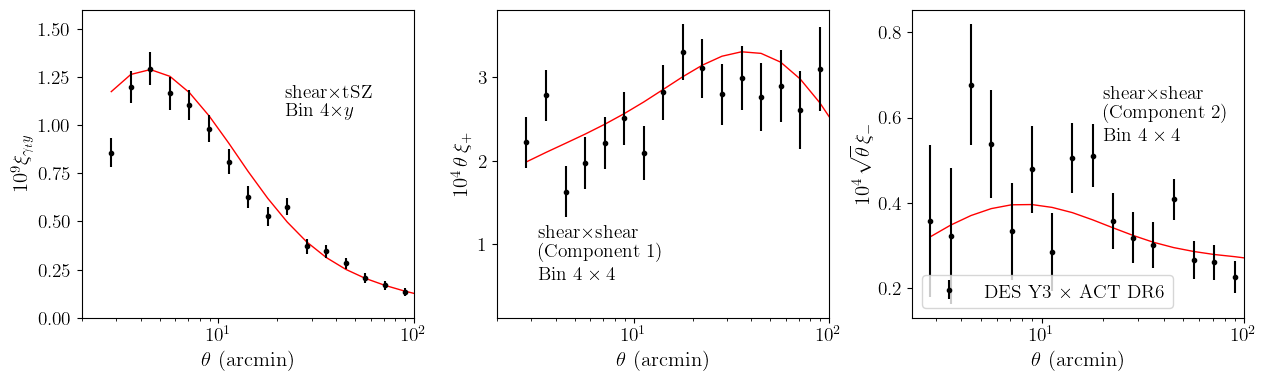

In [330]:
# pl.rc('text', usetex=True)
# # make a three panel plot, plotting all the theta_ej curves for for gty_out_thetaej[:,3,:], xip_out_thetaej[:,3,3,:], xim_out_thetaej[:,3,3,:]
# # draw theta_ej curves from a colormap
# from matplotlib import cm, colorbar
# from matplotlib.colors import Normalize
# from matplotlib.cm import ScalarMappable

# cmap = cm.get_cmap('coolwarm')  # or any other colormap you like
# # create a normalize object the scales the input Mc0 value to the range [0,1]
# # norm = Normalize(vmin=(theta_ej_array).min(), vmax=(theta_ej_array).max())
# # analysis_dict_vary['angles_data_array'] = jnp.logspace(np.log10(0.5), np.log10(100), fac_th * len(theta_data))

# pl.figure(figsize=(15,4))
# # increase the distance between subplots:
# pl.subplots_adjust(wspace=0.25)
# pl.subplot(131)
# color = 'r'
# # for jM in tqdm(range(len(theta_ej_array))):
#     # color = cmap(norm((theta_ej_array[jM])))
# pl.plot(analysis_dict['angles_data_array'], 1e9*get_corrfunc_BCMP_test.gty_out_mat[:,3], color=color, alpha=1.0,lw=1.0)
# # pl.legend()
# # gty_sig_to_plot = np.sqrt(np.diag(DV.fftcovtot_dict['gty_gty']['bin_' + str(j1+1) + '_0_' + str(j2+1) + '_0'][ind_th_sel,:][:,ind_th_sel] ))
# pl.errorbar(analysis_dict['angles_data_array'], 1e9*gty_data_to_plot, yerr=1e9*gty_sig_to_plot, fmt='o', color='k',label='data', ms=3.05)
# pl.text(22, 1.05, r'shear$\times$tSZ' + '\n' + r'Bin 4$\times y$', fontsize=14)
# pl.xscale('log')
# pl.xlim(2.0,100)
# pl.ylim(0.0,1.6)
# pl.ylabel(r'$10^9 \xi_{\gamma_t y}$', fontsize=15)
# pl.xlabel(r'$\theta$ (arcmin)', fontsize=15)
# # set tick label sizes:
# pl.tick_params(axis='both', which='major', labelsize=14)
# pl.tick_params(axis='both', which='minor', labelsize=14)
# # pl.title('1-halo term')
# pl.subplot(132)
# # for jM in tqdm(range(len(theta_ej_array))):
#     # color = cmap(norm((theta_ej_array[jM])))
#     # pl.plot(analysis_dict_vary['angles_data_array'], 1e4*xip_out_all[jM,:], color=color, alpha=1.0,lw=1.0)
# pl.plot(analysis_dict['angles_data_array'], 1e4*get_corrfunc_BCMP_test.xip_out_mat[:,3,3]*analysis_dict['angles_data_array'], color=color, alpha=1.0,lw=1.0)    
# # pl.errorbar(analysis_dict['angles_data_array'], 1e4*xip_data_to_plot, yerr=1e4*xip_sig_to_plot, fmt='o', color='k',label='data', ms=3.05)
# pl.errorbar(analysis_dict['angles_data_array'], 1e4*xip_data_to_plot*analysis_dict['angles_data_array'], yerr=1e4*xip_sig_to_plot*analysis_dict['angles_data_array'], fmt='o', color='k',label='data', ms=3.05)
# # pl.legend()
# pl.text(3.25, 0.6, r'shear$\times$shear' + '\n' + '(Component 1)' + '\n' + r'Bin $4 \times 4$', fontsize=14)
# pl.xscale('log')
# # pl.yscale('log')
# pl.xlim(2.0,100)
# # pl.ylim(2.4,4.6)
# pl.ylabel(r'$10^4 \, \theta \, \xi_+$', fontsize=15)
# pl.xlabel(r'$\theta$ (arcmin)', fontsize=15)
# pl.tick_params(axis='both', which='major', labelsize=14)
# pl.tick_params(axis='both', which='minor', labelsize=14)
# # pl.title('2-halo term')
# pl.subplot(133)
# # for jM in tqdm(range(len(theta_ej_array))):
# color = 'r'
#     # pl.plot(analysis_dict_vary['angles_data_array'], 1e5*xim_out_all[jM,:], color=color, alpha=1.0,lw=1.0)
# pl.plot(analysis_dict['angles_data_array'], 1e4*get_corrfunc_BCMP_test.xim_out_mat[:,3,3]*np.sqrt(analysis_dict['angles_data_array']), color=color, alpha=1.0,lw=1.0)    
# # pl.errorbar(analysis_dict['angles_data_array'], 1e5*xim_data_to_plot, yerr=1e5*xim_sig_to_plot, fmt='o', color='k', label=r'LSST (Y1)$\times$SO', ms=3.05)
# pl.errorbar(analysis_dict['angles_data_array'], 1e4*xim_data_to_plot*np.sqrt(analysis_dict['angles_data_array']), yerr=1e4*xim_sig_to_plot*np.sqrt(analysis_dict['angles_data_array']), fmt='o', color='k', label=r'DES Y3 $\times$ ACT DR6', ms=3.05)
# pl.legend(loc='lower left', fontsize=14)
# # pl.legend()
# pl.xscale('log')
# pl.text(20, 0.55, r'shear$\times$shear' + '\n' +'(Component 2)' + '\n' + r'Bin $4 \times 4$', fontsize=14)
# # pl.yscale('log')
# pl.xlim(2.3,100)
# # pl.ylim(0.38,0.6)
# pl.ylabel(r'$10^4 \, \sqrt{\theta} \, \xi_-$', fontsize=15)
# pl.xlabel(r'$\theta$ (arcmin)', fontsize=15)
# # pl.title('2-halo term')
# pl.tick_params(axis='both', which='major', labelsize=14)
# pl.tick_params(axis='both', which='minor', labelsize=14)
# # create a ScalarMappable with the colormap and norm
# # sm = ScalarMappable(cmap=cmap, norm=norm)
# # the array is not used in this case, but normally the values used for the colormap are passed here
# # sm.set_array([])
# # add the colorbar to the figure
# # cbar = pl.colorbar(sm, ax=pl.gcf().get_axes(), orientation='vertical', fraction=0.05, pad=0.01)
# # cbar.set_label(r'$\theta_{\rm ej, 0}$', fontsize=16, rotation=270, labelpad=20)
# # cbar.ax.tick_params(labelsize=15)
# # pl.savefig('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/forecast_dv_lssty1_so.pdf', bbox_inches='tight')






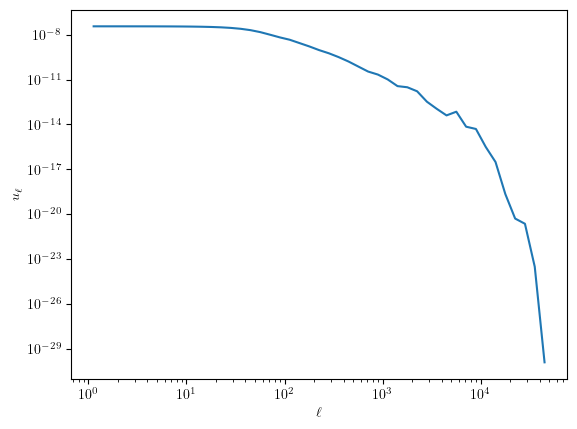

In [300]:
# setup_power_BCMP_obj.uyl_mat.shape
jz = 0
jM = 15
pl.figure()
pl.plot(l_array_survey, np.abs(setup_power_BCMP_obj.uyl_mat[:, jz, jM]))
pl.xscale('log')
pl.yscale('log')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$u_{\ell}$')
pl.show()



In [20]:
DV = get_cov(sim_params_dict, halo_params_dict, analysis_dict, other_params_dict=other_params_dict, 
                  setup_power_BCMP_obj=setup_power_BCMP_obj, get_power_BCMP_obj=get_power_BCMP_obj, verbose_time=False)




do_interpolation:  False


/tmp/ipykernel_328554/2813209991.py:551: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  val_z = sp.integrate.simps(toint_M, np.log(self.M_array))
/tmp/ipykernel_328554/2813209991.py:555: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  val = sp.integrate.simps(toint_z, self.z_array)


array([[1.28650305e-35, 1.28613527e-35, 1.28257956e-35, ...,
        2.39973396e-46, 1.43042933e-50, 3.68912273e-57],
       [1.28613527e-35, 1.28576761e-35, 1.28221287e-35, ...,
        2.39973390e-46, 1.43042926e-50, 3.68912247e-57],
       [1.28257956e-35, 1.28221287e-35, 1.27868438e-35, ...,
        2.39973281e-46, 1.43042875e-50, 3.68911950e-57],
       ...,
       [2.39973396e-46, 2.39973390e-46, 2.39973281e-46, ...,
        5.38384375e-54, 3.31182074e-58, 8.74338497e-65],
       [1.43042933e-50, 1.43042926e-50, 1.43042875e-50, ...,
        3.31182074e-58, 2.04176601e-62, 5.39984412e-69],
       [3.68912273e-57, 3.68912247e-57, 3.68911950e-57, ...,
        8.74338497e-65, 5.39984412e-69, 1.43008970e-75]])

In [32]:
# Cl_yy_theory = DV.Cl_result_dict['yy']['bin_0_0']['tot_ellsurvey']
# Cl_yy_measure = DV.Cl_result_dict['yy']['bin_0_0']['tot_plus_noise_ellsurvey']

# prefac = l_array_survey * (l_array_survey+1) / (2*np.pi)
# pl.figure()
# pl.plot(l_array_survey, prefac*Cl_yy_theory)
# pl.plot(l_array_survey, prefac*Cl_yy_measure)
# pl.xscale('log')
# # pl.yscale('log')
# pl.xlabel(r'$\ell$')
# pl.ylim(1e-21, 2e-11)
# pl.ylabel(r'$C_{\ell, \ell}$')
# pl.show()


In [21]:
# cov_all.fftcovtot_dict['gty_gty']['bin_1_0_1_0'].shape
import pickle as pk
ind_th_sel = np.where( (DV.fftcovtot_dict['ky_ky']['theta'] > 2.5) & (DV.fftcovtot_dict['ky_ky']['theta'] < 250.0))[0]
cov_xip_b44 = DV.fftcovtot_dict['kk_kk']['bin_4_4_4_4'][ind_th_sel,:][:, ind_th_sel]
cov_xim_b44 = DV.fftcovtot_dict['kkm_kkm']['bin_4_4_4_4'][ind_th_sel,:][:, ind_th_sel]
# DV.fftcovtot_dict['kk_kk']['bin_4_4_4_4'].shape
# cov_all.Cl_result_dict['yy']['bin_' + '0_0']['tot_plus_noise_ellsurvey']
# cov_all.Cl_result_dict['yy']['bin_' + '0_0']['tot_ellsurvey']
# DV.fftcovtot_dict.keys()
df = pk.load(open('/Users/shivam/Downloads/DESxACT_gty_xip_xim_DV_ilc_SZ_deproj_cib_cibdBeta_1.7_10.7_yy.pk','rb'))
cov_tot_xim = df['cov_total'][460:480, :][:, 460:480]
cov_tot_xip = df['cov_total'][260:280, :][:, 260:280]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/shivam/Downloads/DESxACT_gty_xip_xim_DV_ilc_SZ_deproj_cib_cibdBeta_1.7_10.7_yy.pk'

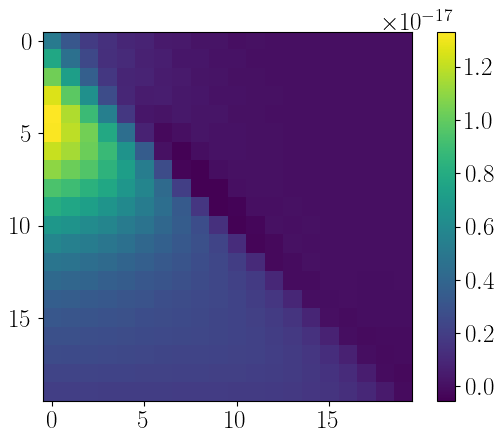

In [110]:
# cov_xim_b44.shape
# cov_tot_xim
cov_gty_xip_b44 = DV.fftcovtot_dict['gty_kk']['bin_4_0_4_4'][ind_th_sel,:][:, ind_th_sel]
pl.figure()
# pl.imshow(cov_tot)
# pl.imshow(np.log(cov_tot_xip))
pl.imshow((cov_gty_xip_b44))
pl.colorbar()



In [107]:
# DV.fftcovtot_dict.keys()


dict_keys(['gty_gty', 'ky_ky', 'gty_kk', 'gty_kkm', 'ky_kk', 'kk_kk', 'kkm_kkm', 'kk_kkm'])

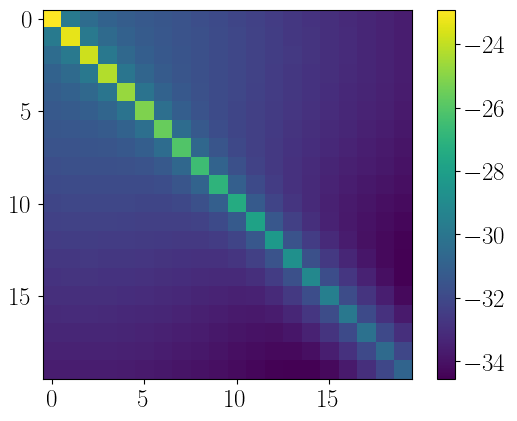

In [106]:
pl.figure()
# pl.imshow(cov_tot)
# pl.imshow(np.log(cov_tot_xip))
pl.imshow(np.log(cov_tot_xim))
pl.colorbar()


/var/folders/pq/42sn_xl53138x3_lbnjsvvjr0000gn/T/ipykernel_2974/2319061889.py:3: RuntimeWarning: invalid value encountered in log
  pl.imshow(np.log(cov_xim_b44))


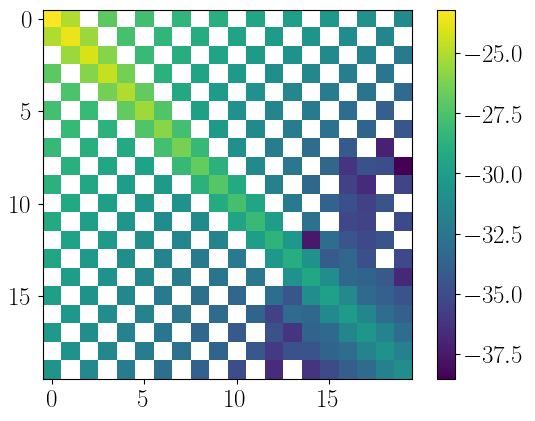

In [105]:
pl.figure()
# pl.imshow(np.log(cov_xip_b44))
pl.imshow(np.log(cov_xim_b44))
pl.colorbar()


In [225]:
# cov_xip_b44


In [237]:
import pickle as pk
df = pk.load(open('/Users/shivam/Downloads/DESxACT_gty_xip_xim_DV_ilc_SZ_deproj_cib_cibdBeta_1.7_10.7_yy.pk','rb'))


In [238]:
nbins = 4
# ntheta_bin = 20
ind_th_sel = np.where( (DV.fftcovtot_dict['gty_gty']['theta'] > 2.5) & (DV.fftcovtot_dict['gty_gty']['theta'] < 250.0))[0]
# cov_gty_gty = np.zeros((ntheta_bin*nbins,ntheta_bin*nbins))
# ldir = '/global/cfs/cdirs/lsst/www/shivamp/cosmosis-standard-library/ACTxDESY3/src/run_measurements/results_27Jan24/'

jstart = 0
for j1 in range(nbins):
    for j2 in range(nbins):
        cov_gty_gty[ntheta_bin*j1:ntheta_bin*(j1+1),ntheta_bin*j2:ntheta_bin*(j2+1)] = DV.fftcovtot_dict['gty_gty']['bin_' + str(j1+1) + '_0_' + str(j2+1) + '_0'][ind_th_sel,:][:,ind_th_sel]   


ValueError: could not broadcast input array from shape (46,46) into shape (20,20)

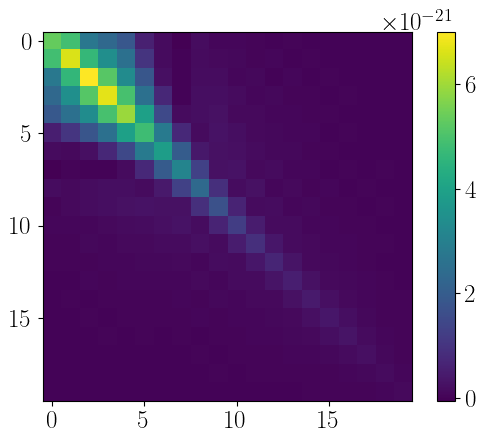

In [92]:
ind_th_sel = np.where( (DV.fftcovtot_dict['ky_ky']['theta'] > 2.5) & (DV.fftcovtot_dict['ky_ky']['theta'] < 250.0))[0]
j1 = 3
j2 = 3
cov_gty_gty = DV.fftcovtot_dict['gty_gty']['bin_' + str(j1+1) + '_0_' + str(j2+1) + '_0'][ind_th_sel,:][:,ind_th_sel]   
pl.figure()
# pl.imshow(np.log(np.abs(cov_gty_gty)))
pl.imshow((cov_gty_gty))
pl.colorbar()
# pl.show()
# pl.xlim(0,10)
# pl.ylim(0,10)


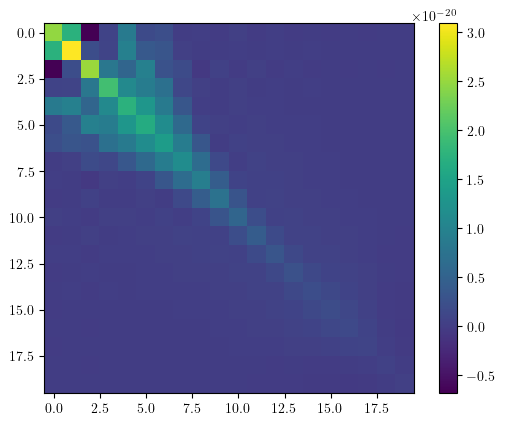

In [327]:
import pickle as pk
df = pk.load(open('/Users/shivam/Downloads/DESxACT_gty_xip_xim_DV_ilc_SZ_deproj_cib_cibdBeta_1.7_10.7_yy.pk','rb'))
# df.keys()
cov_tot = df['cov_total'][60:80, 60:80]

pl.figure()
pl.imshow((cov_tot))
pl.colorbar()


In [206]:
# np.linalg.cond(cov_gty_gty)
import pickle as pk
df = pk.load(open('/Users/shivam/Downloads/DESxACT_gty_xip_xim_DV_ilc_SZ_deproj_cib_cibdBeta_1.7_10.7_yy.pk','rb'))
# df.keys()
cov_tot = df['cov_total'][0:80, 0:80]



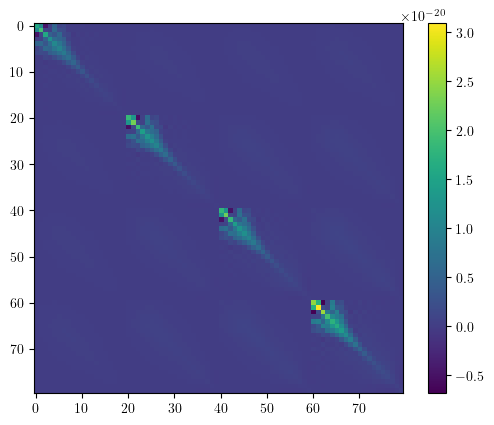

In [207]:
# a1 = np.arange(5)
# a2 = np.arange(5)
# np.allclose(a1, a2)
pl.figure()
pl.imshow((cov_tot))
pl.colorbar()


In [5]:
# %reset
# import get_marked2pt as m2pt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import os
from astropy.io import fits
import dill
import sys, os
sys.path.insert(0, '/Users/shivam/Library/CloudStorage/Dropbox/research/cosmosis_code/')
# import camb
# import LSS_funcs as ghmf
# import general_funcs as gnf
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.unicode'] = True
font = {'size': 18}
matplotlib.rc('font', **font)
# plt.rc('text', usetex=False)
# plt.rc('font', family='DejaVu Serif')



In [35]:
df_name = '/Users/shivam/Downloads/DV_DES_ACT_v1_ky_only_deproj_None_v0_NONGAUSSIANONLY_TEST_GODMAX.pk'
DV_NG = dill.load(open(df_name,'rb'))['DV']

df_name = '/Users/shivam/Downloads/DV_DES_ACT_v1_ky_only_deproj_None_v0_GAUSSIANONLY_TEST_GODMAX.pk'
DV_G = dill.load(open(df_name,'rb'))['DV']




In [38]:
DV_NG.PrepDV.uyl_zM_dict.keys()
# DV_NG.PrepDV.uyl_zM_dict[112.9]


dict_keys([1.1, 1.4, 1.8, 2.3, 2.8, 3.6, 4.5, 5.7, 7.1, 9.0, 11.3, 14.2, 17.9, 22.5, 28.4, 35.7, 45.0, 56.6, 71.3, 89.7, 112.9, 142.2, 179.0, 225.4, 283.7, 357.2, 449.6, 566.1, 712.6, 897.2, 1129.5, 1421.9, 1790.1, 2253.6, 2837.1, 3571.7, 4496.5, 5660.7, 7126.4, 8971.6, 11294.6, 14219.1, 17900.8])

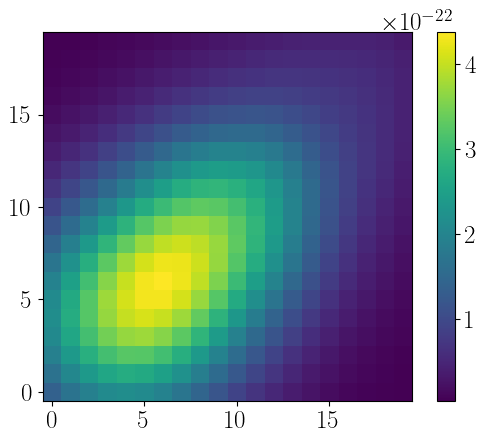

In [24]:
ind_th_sel = np.where( (DV_NG.fftcovtot_dict['ky_ky']['theta'] > 2.5) & (DV_NG.fftcovtot_dict['ky_ky']['theta'] < 250.0))[0]
plt.figure()
plt.imshow(DV_NG.fftcovtot_dict['gty_gty']['bin_4_0_4_0'][ind_th_sel, :][:, ind_th_sel], origin='lower')
plt.colorbar()


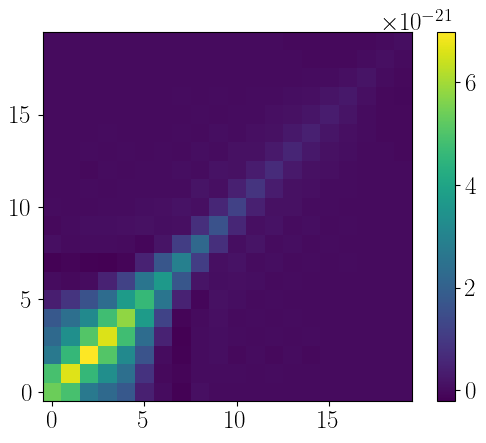

In [25]:
plt.figure()
plt.imshow(DV_G.fftcovtot_dict['gty_gty']['bin_4_0_4_0'][ind_th_sel, :][:, ind_th_sel], origin='lower')
plt.colorbar()


In [88]:
DV.covG_dict['ky_ky']['bin_4_0_4_0']


array([[7.26258554e-23, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.76828146e-23, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.03656199e-23, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.57898388e-34, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.96232005e-35, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.28565455e-35]])

In [89]:
DV_NG.covG_dict['ky_ky']['bin_4_0_4_0']

array([[8.43017698e-23, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.90087734e-23, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.95282956e-23, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.83824053e-42, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.36471429e-44, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 3.96201514e-47]])

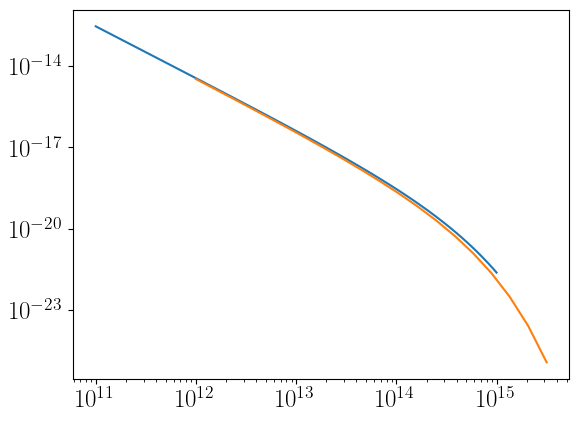

In [58]:
# DV_NG.PrepDV_params['PrepDV_fid'].PS.chi_array, DV_NG.PrepDV_params['PrepDV_fid'].PS.z_array, DV_NG.PrepDV_params['PrepDV_fid'].PS.dchi_dz_array
pl.figure()
# pl.plot(DV_NG.PrepDV_params['PrepDV_fid'].PS.z_array, DV_NG.PrepDV_params['PrepDV_fid'].PS.dchi_dz_array)
# pl.plot(DV.z_array, DV.dchi_dz_array, ls='--')


# pl.plot(DV_NG.PrepDV_params['PrepDV_fid'].PS.z_array, DV_NG.PrepDV_params['PrepDV_fid'].PS.chi_array)
# pl.plot(DV.z_array, DV.chi_array, ls='--')

pl.plot(DV_NG.PrepDV_params['PrepDV_fid'].PS.M_array, DV_NG.PrepDV_params['PrepDV_fid'].PS.dndm_array[0,:])
pl.plot(DV.M_array, (1/DV.M_array)*DV.dndlnM_z[0,:])
pl.xscale('log')
pl.yscale('log')
# pl.plot(DV.z_array, DV.chi_array, ls='--')




In [55]:
# DV_NG.PrepDV_params['PrepDV_fid'].PS.dndm_array.shape
DV.dndlnM_z.shape


(20, 20)